#### This notebook solves the equations of motion for the UV theory and its screening properties

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import dolfin as d
import numpy as np

from atexpmesh import ArcTanExpMesh
from atplmesh import ArcTanPowerLawMesh

from fem import Fem
from tophatsource import TopHatSource, StepSource
from cossource import CosSource
from gcakesource import GCakeSource

from UV import UVFields, UVSolver
from gravity import PoissonSolver

from utils import project, get_values

First define the problem and the mesh. Every parameter not defined here will be set to its default value.

In [2]:
# mesh and finite element settings
mesh = ArcTanExpMesh( num_cells=250, r_min=0., r_max=1e9, k=20., b=1e-2, 
                     linear_refine=2, linear_start=1.05, linear_stop=1.2,
                     adjust_transition=True )
fem = Fem( mesh, func_degree=5 )

In [3]:
# source and UV fields
source = TopHatSource( fem, Ms=1e10, Rs=1e47, w=0.02 )
fields = UVFields( m=1e-48, M=1e-46 )

In [4]:
# define the problem and solve
uvs = UVSolver( fem, source, fields, 
                rel_res_tol=1e-100, abs_res_tol=1e-83, max_iter=50 )
uvs.solve()

Non-linear solver, iteration 0	abs_du = 2.6e-02	rel_du = 1.1e-01	abs_res = 1.2e+08 (tol = 1.0e-83)	rel_res = 1.0e+00 (tol = 1.0e-100)
Non-linear solver, iteration 1	abs_du = 1.7e-02	rel_du = 7.2e-02	abs_res = 3.5e+07 (tol = 1.0e-83)	rel_res = 3.0e-01 (tol = 1.0e-100)
Non-linear solver, iteration 2	abs_du = 1.1e-02	rel_du = 4.8e-02	abs_res = 1.0e+07 (tol = 1.0e-83)	rel_res = 8.8e-02 (tol = 1.0e-100)
Non-linear solver, iteration 3	abs_du = 7.6e-03	rel_du = 3.2e-02	abs_res = 3.1e+06 (tol = 1.0e-83)	rel_res = 2.6e-02 (tol = 1.0e-100)
Non-linear solver, iteration 4	abs_du = 5.1e-03	rel_du = 2.1e-02	abs_res = 9.1e+05 (tol = 1.0e-83)	rel_res = 7.7e-03 (tol = 1.0e-100)
Non-linear solver, iteration 5	abs_du = 3.4e-03	rel_du = 1.4e-02	abs_res = 2.7e+05 (tol = 1.0e-83)	rel_res = 2.3e-03 (tol = 1.0e-100)
Non-linear solver, iteration 6	abs_du = 2.3e-03	rel_du = 9.4e-03	abs_res = 8.0e+04 (tol = 1.0e-83)	rel_res = 6.8e-04 (tol = 1.0e-100)
Non-linear solver, iteration 7	abs_du = 1.5e-03	rel_du = 6.3e-

This is where your mesh vertices are distributed. You can explore more properties of your mesh using one of the notebooks provided: ATEMesh.ipynb, EMesh.ipynb or QMesh.ipynb

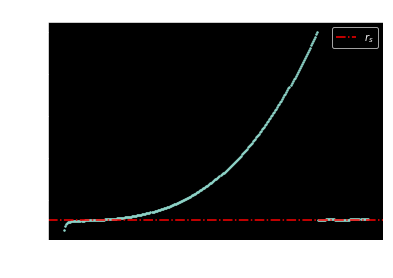

In [5]:
plt.title('Mesh vertices')
plt.plot( mesh.mesh.coordinates(), '.', markersize='3' )
plt.ylabel(r'$r$')
plt.xlabel('index')
plt.axhline(y=mesh.rs, color='red', linestyle='-.', label=r'$r_s$')
plt.yscale('log')
plt.legend()

This is what your source looks like (around the source-vacuum transition)

(0.0, 3)

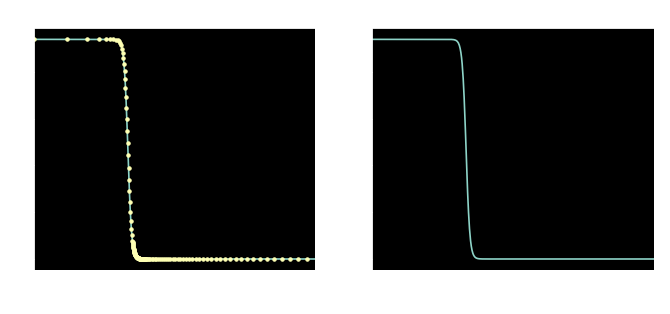

In [6]:
fig=plt.figure(figsize=(10, 4), dpi=80 )#, facecolor='w', edgecolor='k')

# cast rho as a Function (not necessary for plotting, but helpful to compute
# On operators later)

plt.subplot(121)
plt.title(r'$\rho$ ($M_p^4$)')
rho = d.interpolate( source.rho, fem.S )
r_values, rho_values = get_values( rho, output_mesh=True )
Rho_values = uvs.Mn**3 * rho_values # get physical units
plt.plot( r_values, Rho_values )
plt.plot( r_values, Rho_values, '.' )
plt.xlabel(r'$r/r_s$')
plt.xlim([0., 3])

# using units Mp^4
plt.subplot(122)
plt.title(r'$\rho$ ($M_p^4$)')
plt.plot( r_values, Rho_values, '-' )
plt.xlabel(r'$r/r_s$')
plt.xlim([ 0., 3 ])

If you want to check your model parameters, uncomment this line

In [7]:
#fields.__dict__

If you want to check your source parameters, uncomment this line

In [8]:
source.__dict__

{'A': 2347386356.8171,
 'Ms': 10000000000.0,
 'Rs': 1e+47,
 'f': 0.95,
 'fem': <fem.Fem at 0x7faf1e2aae50>,
 'from_lut': True,
 'lut_dir': './lut/',
 'lut_root': 'top_hat_',
 'lut_tmax': 1.2,
 'lut_tmin': 0.8,
 'lut_tnum': 100,
 'lut_wmax': 0.7,
 'lut_wmin': 0.0001,
 'lut_wnum': 300,
 'rho': Coefficient(FunctionSpace(None, FiniteElement('Lagrange', None, 5)), 15),
 't': 1.0043308127901334,
 't0': 1.0040404040404041,
 'w': 0.02}

And if you want to check your mesh or FEM parameters, uncomment one of these lines

In [9]:
#mesh.__dict__
#fem.__dict__

#####    
Check the solver has finished: you should see a plateau in these two plots

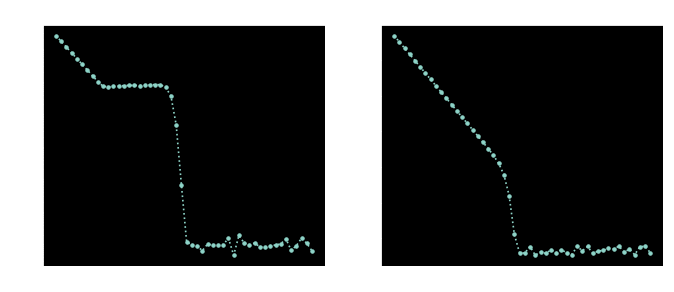

In [10]:
fig=plt.figure(figsize=(10, 4), dpi=80 )#, facecolor='w', edgecolor='k')

abs_du = uvs.abs_du
abs_res = uvs.abs_res

# change in the solution (du) at every iteration
plt.subplot(121)
plt.title('Absolute du, norm=%s' % uvs.norm_change )
plt.plot( abs_du[abs_du>0.], ':.' )
#plt.xlim([0,40])
plt.yscale('log')

# weak residual at every iteration
plt.subplot(122)
plt.title('Absolute res, norm=%s' % uvs.norm_res )
plt.plot( abs_res[abs_res>0.], ':.' )
#plt.xlim([0,40])
plt.yscale('log')

#####    
Print the _strong_ residual (i.e. difference bw two sides of equations) across the whole box, as well as the maximum residual at vertices
WARNING: if your interpolating polynomials are degree less than 3 these numbers will not be reliable

In [11]:
print 'absolute residual (L2 norm over the whole box): %.1e' % uvs.strong_residual( uvs.u, norm='L2' )
print 'absolute max residual at vertices: %.1e' % uvs.strong_residual( uvs.u, norm='linf' )

print '\nMax abs value at vertices:'
print 'LHS of Eq. 1:', uvs.output_term( eqn=1, term='LHS', norm='linf' )
print 'RHS of Eq. 1:', uvs.output_term( eqn=1, term='RHS', norm='linf' )
print 'LHS of Eq. 2:', uvs.output_term( eqn=2, term='LHS', norm='linf' )
print 'RHS of Eq. 2:', uvs.output_term( eqn=2, term='RHS', norm='linf' )

absolute residual (L2 norm over the whole box): 3.4e-08
absolute max residual at vertices: 4.9e-07

Max abs value at vertices:
LHS of Eq. 1: 0.234738635682
RHS of Eq. 1: 0.234738635682
LHS of Eq. 2: 0.233821291828
RHS of Eq. 2: 0.233821291827


#####      
Extract value of phi/H/Y/Z at vertices, for plotting - physical units

In [12]:
Phi, H, Y, Z = uvs.Phi, uvs.H, uvs.Y, uvs.Z
r_values, Phi_values = get_values( Phi, output_mesh=True )
H_values = get_values(H)
Y_values = get_values(Y)
Z_values = get_values(Z)

get strong residual at all mesh vertices, for plotting

In [13]:
F = uvs.strong_residual( uvs.u, norm='none', units='rescaled' )
F1, F2, F3, F4 = F.split(deepcopy=True) # residuals for Eq1, 2, 3, and 4
F1_values = get_values(F1)
F2_values = get_values(F2)
F3_values = get_values(F3)
F4_values = get_values(F4)
# useful for log scale
F1_mask = ( F1_values > 0. )
F2_mask = ( F2_values > 0. )
F3_mask = ( F3_values > 0. )
F4_mask = ( F4_values > 0. )

######    
compare the different terms in the equations. Adjust y limits in this plot as well as all others below (unfortunately, it's difficult to predict those limits)

(0.1, 10000.0)

/usr/local/lib/python2.7/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


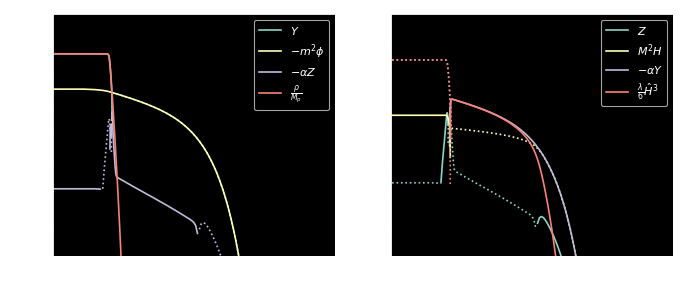

In [14]:
fig=plt.figure(figsize=(10, 4), dpi=80 )


# equation 1
plt.subplot(121)
for j in range(1,5):
    term, label = uvs.output_term( eqn=1, term=j, units='physical', output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )
plt.xscale('log')
plt.yscale('log')
#plt.legend(bbox_to_anchor=(-0.2,0.7))
plt.legend()
plt.ylim( 1e-145,1e-129 )
plt.xlim(1e-1, 1e4)


# equation 2

plt.subplot(122)
for j in range(1,5):
    term, label = uvs.output_term( eqn=2, term=j, units='physical', output_label=True )
    term_values = get_values( term )
#    plt.plot( r_values, abs(term_values), label=label )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim( 1e-145,1e-129 )
plt.xlim(1e-1, 1e4)

(0.001, 1000000000.0)

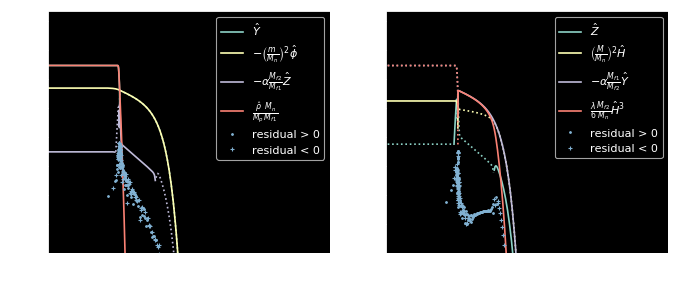

In [15]:
fig=plt.figure(figsize=(10, 4), dpi=80 )


# equation 1
plt.subplot(121)
for j in range(1,5):
    term, label = uvs.output_term( eqn=1, term=j, units='rescaled', output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )
    
# plot strong residual values
colour = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot( r_values[F1_mask], F1_values[F1_mask], '.', markersize='3', color=colour,
         label='residual > 0' )
plt.plot( r_values[~F1_mask], abs(F1_values[~F1_mask]), '+', markersize='3', color=colour,
         label='residual < 0' )

plt.xscale('log')
plt.yscale('log')
#plt.legend(bbox_to_anchor=(-0.2,0.7))
plt.legend()
plt.ylim([1e-20, 1e5])
plt.xlim(1e-3, 1e9)


# equation 2
plt.subplot(122)
for j in range(1,5):
    term, label = uvs.output_term( eqn=2, term=j, units='rescaled', output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )
    
# plot strong residual values
colour = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot( r_values[F2_mask], F2_values[F2_mask], '.', markersize='3', color=colour,
         label='residual > 0' )
plt.plot( r_values[~F2_mask], abs(F2_values[~F2_mask]), '+', markersize='3', color=colour,
         label='residual < 0' )

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([1e-20, 1e5])
plt.xlim(1e-3, 1e9)

######     
consistency of Y = Del phi and Z = Del H. Adjust y limits in this plot as well as all others below (unfortunately, it's difficult to predict those limits)

(1e-30, 100000.0)

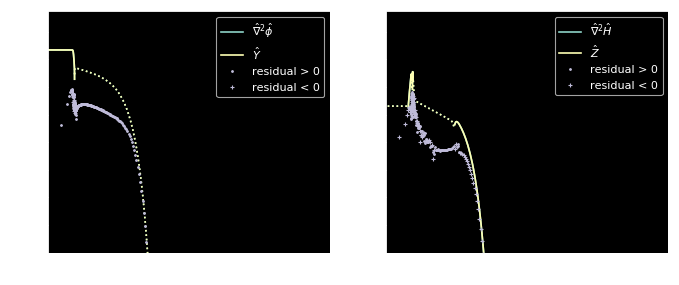

In [16]:
fig=plt.figure(figsize=(10, 4), dpi=80 )

# equation 3
plt.subplot(121)
for j in range(1,3):
    term, label = uvs.output_term( eqn=3, term=j, units='rescaled', output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )
    
# plot strong residual values
colour = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot( r_values[F3_mask], F3_values[F3_mask], '.', color=colour,
         markersize='3', label='residual > 0' )
plt.plot( r_values[~F3_mask], abs(F3_values[~F3_mask]), '+', color=colour,
         markersize='3', label='residual < 0' )

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([1e-30, 1e5])
#plt.xlim(1e-3, 1e3)

# equation 2
plt.subplot(122)
for j in range(1,3):
    term, label = uvs.output_term( eqn=4, term=j, units='rescaled', output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )
    
# plot strong residual values
# sets same colour for both lines
colour = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot( r_values[F4_mask], F4_values[F4_mask], '.', markersize='3', color=colour,
         label='residual > 0' )
plt.plot( r_values[~F4_mask], abs(F4_values[~F4_mask]), '+', markersize='3', color=colour,
         label='residual < 0' )

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([1e-30, 1e5])
#plt.xlim(1e-3, 1e3)

######      
Compare the two sides of the equations and the strong residuals

(1e-30, 100000.0)

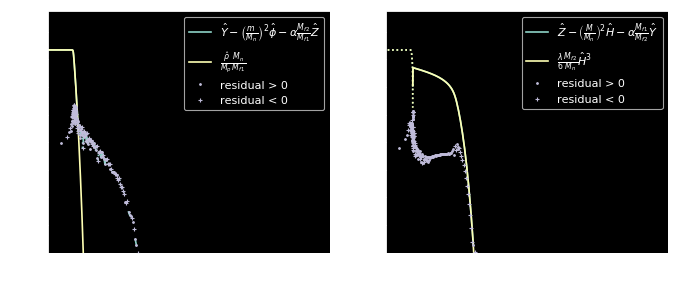

In [17]:
fig=plt.figure(figsize=(10, 4), dpi=80 )#, facecolor='w', edgecolor='k')
plt.title('Terms comparison: dots when >0, crosses when < 0')


# equation 1
plt.subplot(121)
for i, side in enumerate(['LHS','RHS']):
    term, label = uvs.output_term( eqn=1, term=side, units='rescaled', output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )

# plot strong residual values
colour = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot( r_values[F1_mask], F1_values[F1_mask], '.', markersize='3', color=colour,
         label='residual > 0' )
plt.plot( r_values[~F1_mask], abs(F1_values[~F1_mask]), '+', markersize='3', color=colour,
         label='residual < 0' )

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([1e-30, 1e5])

# equation 2
plt.subplot(122)
for i, side in enumerate(['LHS','RHS']):
    term, label = uvs.output_term( eqn=2, term=side, units='rescaled', output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )
    
# plot strong residual values
colour = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot( r_values[F2_mask], F2_values[F2_mask], '.', markersize='3', color=colour,
         label='residual > 0' )
plt.plot( r_values[~F2_mask], abs(F2_values[~F2_mask]), '+', markersize='3', color=colour,
         label='residual < 0' )

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([1e-30, 1e5])

######   
Now we have checked some diagnostic plots we can look at the solution

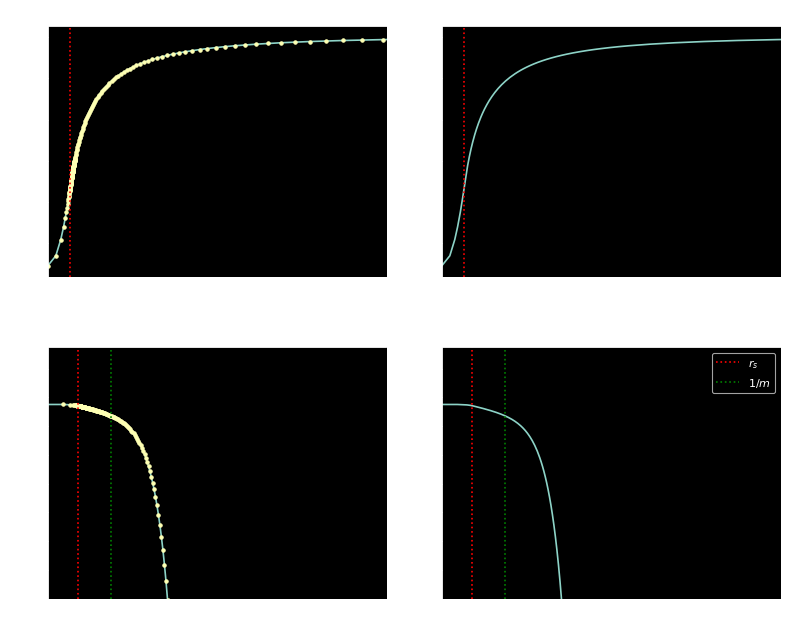

In [18]:
# for ease of visualisation, only plot function up to...
Phi_r_stop = mesh.rs * 15.

fig=plt.figure(figsize=(10, 8), dpi=80 )

# field around the source
plt.subplot(221)
plt.title(r'$\phi$ (Mp), around the source')
plt.plot( r_values, Phi_values )
plt.plot( r_values, Phi_values, '.' )
plt.xlabel(r'$r/r_s$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=uvs.fem.mesh.rs, color='red', linestyle=':')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim([0., Phi_r_stop])

plt.subplot(222)
plt.title(r'$\phi$ (Mp), around the source')
plt.plot( r_values, Phi_values )
plt.xlabel(r'$\hat{r}=r/r_s$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=uvs.fem.mesh.rs, color='red', linestyle=':')
plt.xlim([ 0., Phi_r_stop ])

# field across the whole box
plt.subplot(223)
plt.title(r'$\phi$ (Mp) - whole box')
plt.plot( r_values, abs(Phi_values) )
plt.plot( r_values, abs(Phi_values), '.' )
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=uvs.fem.mesh.rs, color='red', linestyle=':', label=r'$r_s$')
plt.axvline(x=uvs.Mn / fields.m, linestyle=':', color='green', label=r'$1/m$')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-65, 1e-30])
#plt.xlim(1e-7, 1e9)

plt.subplot(224)
plt.title(r'$\phi$ (Mp) - whole box')
plt.plot( r_values, abs(Phi_values) )
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=mesh.rs, color='red', linestyle=':', label=r'$r_s$')
plt.axvline(x=uvs.Mn / fields.m, linestyle=':', color='green', label=r'$1/m$')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-65, 1e-30])
#plt.xlim(1e-7, 1e9)

plt.legend()
plt.tight_layout()

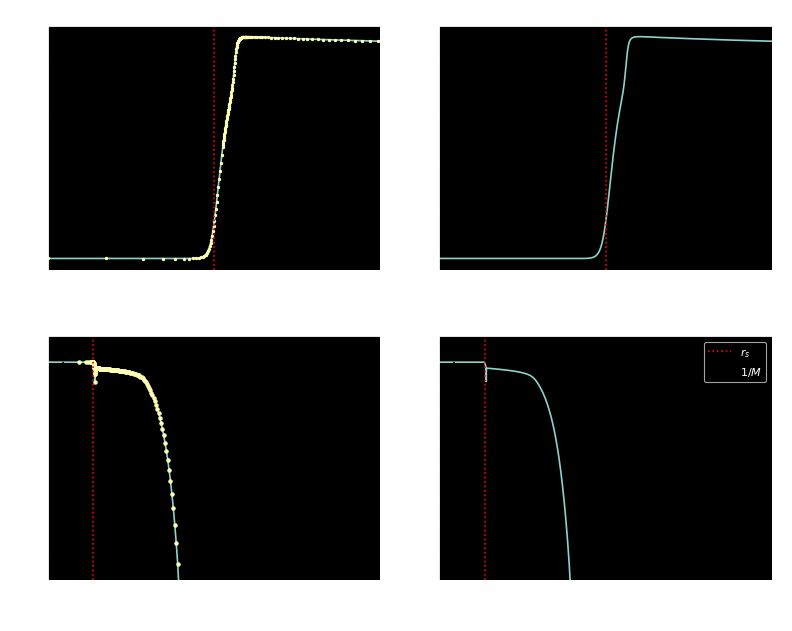

In [19]:
# for ease of visualisation, only plot function up to...
H_r_stop = mesh.rs * 2.

fig=plt.figure(figsize=(10, 8), dpi=80 )

# field around the source
plt.subplot(221)
plt.title(r'$H$ ($M_p$), around the source')
plt.plot( r_values, H_values )
plt.plot( r_values, H_values, '.', markersize='4' )
plt.xlabel(r'$r/r_s$')
plt.axvline( x=uvs.fem.mesh.rs, color='red', linestyle=':' )
plt.xlim([ 0., H_r_stop ])

plt.subplot(222)
plt.title(r'$H$ ($M_p$), around the source')
plt.plot( r_values, H_values )
plt.xlabel(r'$r/r_s$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline( x=uvs.fem.mesh.rs, color='red', linestyle=':' )
plt.xlim([ 0., H_r_stop ])

# field across the whole box
plt.subplot(223)
plt.title(r'$H$ (Mp) - whole box')
plt.plot( r_values, abs(H_values) )
plt.plot( r_values, abs(H_values), '.' )
plt.xlabel(r'$r/r_s$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline( x=uvs.fem.mesh.rs, color='red', linestyle=':', label=r'$r_s$' )
plt.axvline( x=uvs.Mn / uvs.fields.M, linestyle=':', color='k', label=r'$1/M$' )
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-75, 1e-40])

plt.subplot(224)
plt.title(r'$H$ (Mp) - whole box')
plt.plot( r_values, abs(H_values) )
plt.xlabel(r'$r/r_s$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline( x=uvs.fem.mesh.rs, color='red', linestyle=':', label=r'$r_s$' )
plt.axvline( x=uvs.Mn / uvs.fields.M, linestyle=':', color='k', label=r'$1/M$' )
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-75, 1e-40])

plt.legend()
plt.tight_layout()

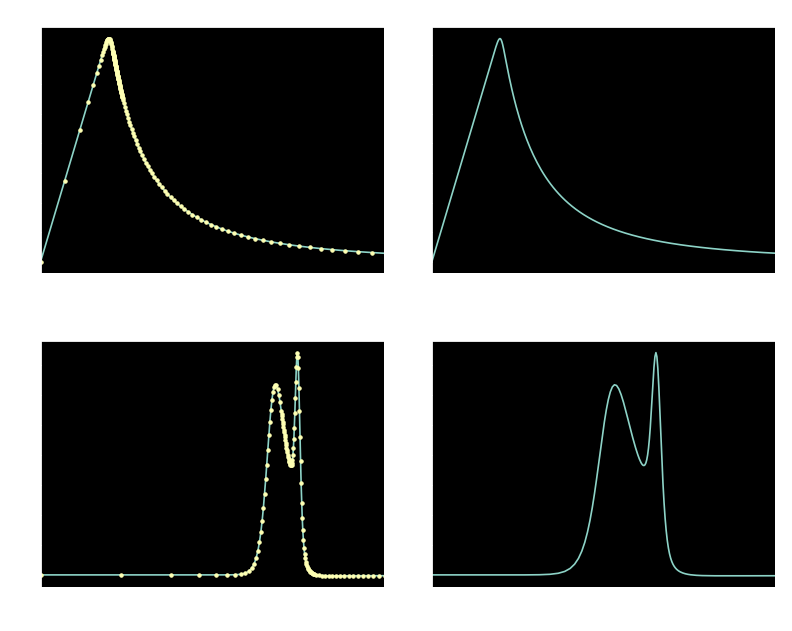

In [20]:
# gradients
fig=plt.figure(figsize=(10, 8), dpi=80 )

# phi
plt.subplot(221)
plt.title(r'$\nabla\phi$ ($M_p^2$), around the source')
grad_Phi_values = get_values( uvs.grad_Phi )
plt.plot( r_values, grad_Phi_values, '-' )
plt.plot( r_values, grad_Phi_values, '.' )

plt.xlabel(r'$r/r_s$')
plt.xlim( 0., uvs.fem.mesh.rs * 5. )

plt.subplot(222)
plt.title(r'$\nabla\phi$ ($M_p^2$), around the source')
plt.plot( r_values, grad_Phi_values, '-' )
plt.xlabel(r'$r/r_s$')
plt.xlim( 0., uvs.fem.mesh.rs * 5. )

# H
plt.subplot(223)
plt.title(r'$\nabla H$ ($M_p^2$), around the source')
grad_H_values = get_values( uvs.grad_H )
plt.plot( r_values, grad_H_values, '-' )
plt.plot( r_values, grad_H_values, '.' )
#plt.xlim( 0., uvs.mesh.rs * 5. )
plt.xlabel(r'$r/r_s$')
plt.xlim(0., 1.5)
#plt.yscale('log')
#plt.ylim([-1e-55, 3e-55])

plt.subplot(224)
plt.title(r'$\nabla H$ ($M_p^2$), around the source')
plt.plot( r_values, grad_H_values, '-' )
plt.xlabel(r'$r/r_s$')
plt.xlim( 0.6, 1.4 )

plt.tight_layout()

#####     
comparison of some scales: rs, rV, 1/M, 1/m, r_max

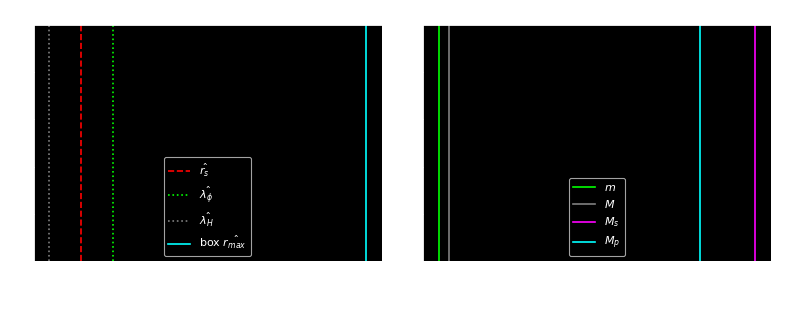

In [21]:
fig=plt.figure(figsize=(10, 4), dpi=80 )#, facecolor='w', edgecolor='k')

# plot adimensional scales
plt.subplot(121)
plt.title('Some scales')
plt.axvline( x = uvs.fem.mesh.rs, color='r', linestyle='--', label=r'$\hat{r_s}$' )
plt.axvline( x = uvs.Mn * 1/uvs.fields.m, color='lime', linestyle=':', label=r'$\hat{\lambda_{\phi}}$')
plt.axvline( x = uvs.Mn * 1/uvs.fields.M, color='grey', linestyle=':', label=r'$\hat{\lambda_H}$')
plt.axvline( x = uvs.fem.mesh.r_max, color='cyan', linestyle='-', label=r'box $\hat{r_{max}}$' )
plt.xlabel(r'$r/r_s$')
plt.xscale('log')
plt.legend()


# plot and compare mass scales: m, M, Ms, Mp
plt.subplot(122)
plt.title('Some masses in units 1/Mp')
plt.axvline( x=uvs.fields.m, ls='-', color='lime', label=r'$m$' )
plt.axvline( x=uvs.fields.M, ls='-', color='grey', label=r'$M$' )
plt.axvline( x=uvs.source.Ms, ls='-', color='magenta', label=r'$M_s$')
plt.axvline( x=uvs.fields.Mp, ls='-', color='cyan', label=r'$M_p$')
plt.xlabel('mass')
plt.xscale('log')
plt.legend()

plt.tight_layout()

#####    
Now compute the Newton force by solving the Poisson equation

(1e-180, 1e-130)

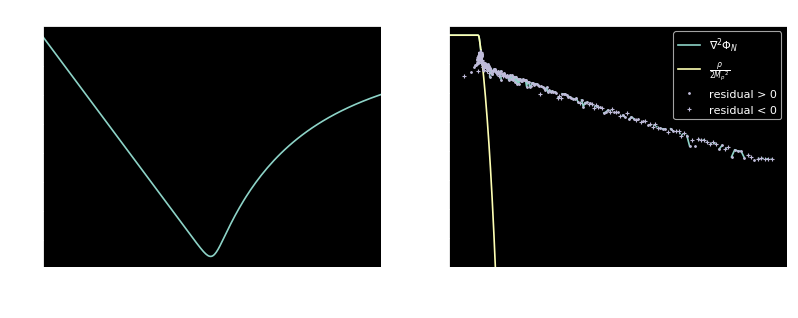

In [22]:
gs = PoissonSolver( fem, source )
gs.solve()
Newton_values = get_values( gs.Newton_force )
gF_values = get_values( gs.strong_residual( gs.PhiN, norm='none', units='physical' ) )
gF_mask = ( gF_values > 0. )


fig=plt.figure(figsize=(12, 4), dpi=80 )

plt.subplot(121)
plt.title(r'$F_N$ in units 1/Mp')
plt.plot( r_values, Newton_values, '-' )
plt.xlim( 0., gs.fem.mesh.rs * 2. )
plt.xlabel(r'$r/r_s$')

plt.subplot(122)
plt.title(r'Gravitational field - residuals')
for i, side in enumerate(['LHS','RHS']):
    term, label = gs.output_term( term=side, units='physical', output_label=True )
    term_values = get_values( term )
    term_pos = np.ma.masked_where( term_values < 0., term_values )
    term_neg = np.ma.masked_where( term_values > 0., term_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, term_pos, '-', label=label, color=colour )
    plt.plot( r_values, abs(term_neg), ':', label=label, color=colour )

# plot strong residual values
colour = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot( r_values[gF_mask], gF_values[gF_mask], '.', markersize='3', color=colour,
         label='residual > 0' )
plt.plot( r_values[~gF_mask], abs(gF_values[~gF_mask]), '+', markersize='3', color=colour,
         label='residual < 0' )

plt.xlabel(r'$r/r_s$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim(1e-180,1e-130)

######  
compare strength of scalar vs Newton force: a value of two in the scalar/Newton force ratio indicates they are the same strength (as a consequence of our normalisation) a value of 2 or higher indicates there is no screening

Text(0.5,0,u'$r/r_s$')

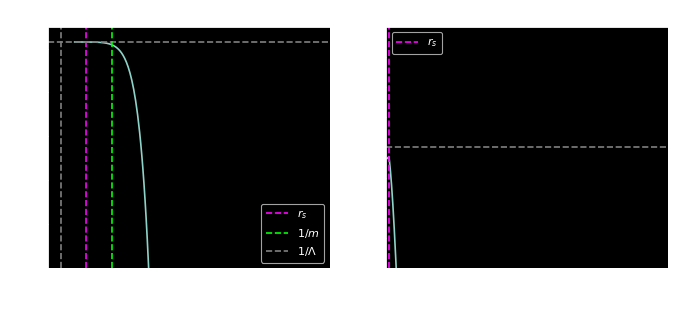

In [23]:
fig=plt.figure(figsize=(10, 4), dpi=80 )

plt.subplot(121)
plt.title(r'$F_{\pi}/F_N$')

Pi_force_values = get_values( uvs.force )

comparison = Pi_force_values / Newton_values
# sets same colour for both lines
colour = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot( r_values[1:], comparison[1:], '-', color=colour )
#plt.plot( r_values, comparison, '.', color=colour )
plt.xlabel(r'$r/r_s$')

plt.axvline( x = uvs.fem.mesh.rs, ls='--', color='magenta', label=r'$r_s$' )
plt.axhline( y = 2., color='grey', ls='--' )
plt.axvline( x = uvs.Mn/uvs.fields.m, ls='--',  color='lime', label=r'$1/m$')
plt.axvline( x = uvs.Mn/uvs.fields.M, ls='--', color='grey', label=r'$1/\Lambda$')

plt.xlabel('r')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-10,1e1])
#plt.xlim(1e45,1e50)
plt.legend()


plt.subplot(122)
plt.title(r'$F_{\pi}/F_N$ - around the source')

plt.plot( r_values[1:], comparison[1:], '-' )

plt.axvline( x = uvs.fem.mesh.rs, ls='--', color='magenta', label=r'$r_s$' )
plt.axhline( y = 2., color='grey', ls='--' )
plt.legend(loc=2)
plt.xlim( 0., uvs.fem.mesh.rs * 100. )
plt.ylim(2-1e-1,2+1e-1)
plt.xlabel(r'$r/r_s$')

######      
IR operators. Plot the On operator for some n first

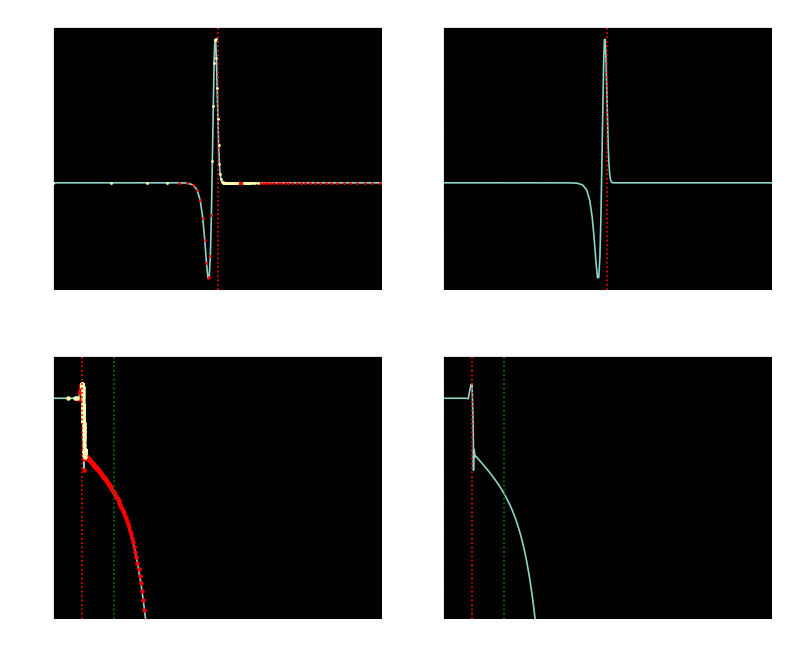

In [24]:
n = 3

On_Phi = uvs.On( n )
On_values = get_values( On_Phi )
On_mask = ( On_values > 0. )

# make figure
fig=plt.figure(figsize=(10, 8.5), dpi=80 )

# in linear scale, for ease of visualisation stop at this r
On_stop = 2. * uvs.fem.mesh.rs

# operator around the source
plt.subplot(221)
plt.title( r'$O_{%d}$, around the source' % n )
plt.plot( r_values, On_values )
plt.plot( r_values[~On_mask], On_values[~On_mask], 'r.', markersize='3' )
plt.plot( r_values[On_mask], On_values[On_mask], '.', markersize='3' )
plt.xlabel(r'$r/r_s$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=uvs.fem.mesh.rs, color='red', linestyle=':')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim(0., On_stop)

plt.subplot(222)
plt.title(r'$O_{%d}$ ($M_p^3$), around the source' % n)
plt.plot( r_values, On_values, '-' )
plt.xlabel(r'$r/r_s$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=uvs.fem.mesh.rs, color='red', linestyle=':')
plt.xlim([ 0., On_stop ])

# operator across the whole box
plt.subplot(223)
plt.title( r'$O_{%d}$, whole box' % n )
plt.plot( r_values, abs(On_values) )
plt.plot( r_values[~On_mask], abs(On_values[~On_mask]), 'r.' )
plt.plot( r_values[On_mask], abs(On_values[On_mask]), '.' )
plt.xlabel(r'$\hat{r}$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=uvs.fem.mesh.rs, color='red', linestyle=':')
plt.axvline(x=uvs.Mn / uvs.fields.m, linestyle=':', color='green')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-162, 1e-90])
#plt.xlim(1e-2, 1e9)

# original operator across the whole box
plt.subplot(224)
plt.title(r'$O_n$ - whole box')
plt.plot( r_values, abs(On_values) )
plt.xlabel(r'$r$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=uvs.fem.mesh.rs, color='red', linestyle=':')
plt.axvline(x=uvs.Mn/uvs.fields.m, linestyle=':', color='green')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-162, 1e-90])
#plt.xlim(1., 1.5)

plt.tight_layout()

#####   
Compare some On operators in log scale

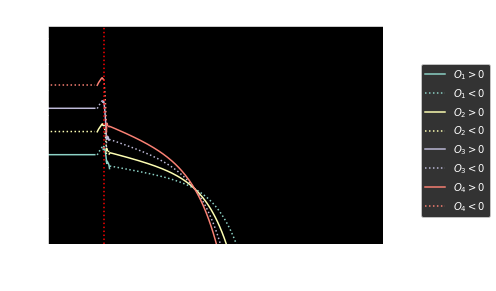

In [25]:
# Comparison of a few operators in log scale

plt.title(r'$On$ in $M_p^3$, across box')
K_array = np.ones(10)
#K_array[1] = 1e10
#K_array[2] = 1e20#1e5
#K_array[3] = 1e40#1e30
#K_array[4] = 1e40#1e30
for n in range(1,5):
    phys_On = uvs.On( n )#, rescale=K_array[n] )
    phys_On_values = get_values( phys_On )
    phys_On_pos = np.ma.masked_where( phys_On_values < 0., phys_On_values )
    phys_On_neg = np.ma.masked_where( phys_On_values > 0., phys_On_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, phys_On_pos, '-', label=r'$O_{%d}>0$' % n, color=colour )
    plt.plot( r_values, abs(phys_On_neg), ':', label=r'$O_{%d}<0$' % n, color=colour )
    plt.xlabel(r'$\hat{r}$')
       
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=uvs.fem.mesh.rs, color='red', linestyle=':')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-170,1e-60)
plt.xlim(1e-1,1e5)
plt.legend(bbox_to_anchor=(1.1,.1), loc='lower left')

######    
Compare the Qn operators

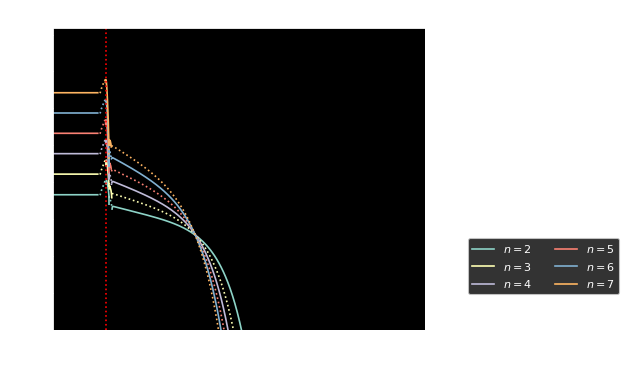

In [26]:
# Even and odd operators together

fig=plt.figure(figsize=(6, 5), dpi=80 )

plt.title(r'$Q_n$ in units $M_p^3$')
K_array = np.ones(10)
#K_array[2] = 1e10
#K_array[3] = 1e20
#K_array[4] = 1e20
#K_array[5] = 1e30
#K_array[6] = 1e30
#K_array[7] = 1e40
for n in range(2,8):
    Qn_phys = uvs.Qn( n )#, rescale=K_array[n] )
    Qn_values = get_values( Qn_phys )
    Qn_pos = np.ma.masked_where( Qn_values < 0., Qn_values )
    Qn_neg = np.ma.masked_where( Qn_values > 0., Qn_values )
    # sets same colour for both lines
    colour = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot( r_values, Qn_pos, '-', label=r'$n=%d$' % n, color=colour )
    plt.plot( r_values, abs(Qn_neg), ':', color=colour )
    plt.xlabel(r'$\hat{r}$')
       

plt.axvline(x=uvs.fem.mesh.rs, color='red', linestyle=':')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-1, 1e6)
plt.ylim(1e-170,1e-80)
plt.legend(bbox_to_anchor=(1.1,.1), loc='lower left', ncol=2)